# YELP - Natural Language Processing

In this NLP project I will deal with basic data analysis, among other things. We will create lists of the top best and worst rated businesses. We will also create a list of the most active reviewers and check their vocabulary, and we will create word clouds. All this before clearing the data first. At the end I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import string
import re

%matplotlib inline

## EDA & Data Cleaning

In [2]:
yelp = pd.read_csv('yelp.csv')

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
sns.set_style('whitegrid')

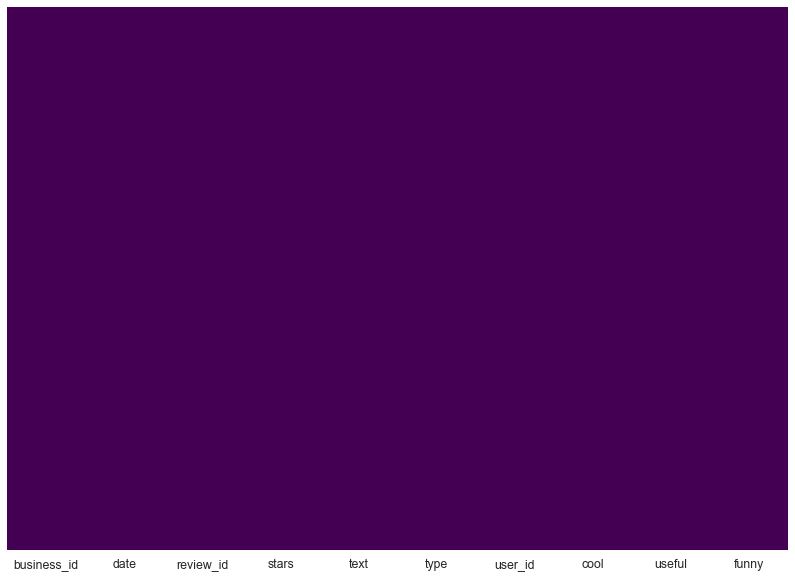

In [6]:
# lOOKING FOR NANVALUE
plt.figure(figsize=(14,10))
sns.set_context('paper', font_scale=1.4)

sns.heatmap(yelp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
# How many businesses are there?
yelp['business_id'].nunique()

4174

In [8]:
# List of business_id
business_unique = yelp['business_id'].unique()


rows = []
  
for i, c in enumerate(business_unique):
    x = yelp[yelp['business_id'] == c]['text'].count()
    y = yelp[yelp['business_id'] == c]['user_id'].nunique()
    rows.append([c, x, y])
df = pd.DataFrame(rows, columns=["business_id", "Number of review", "Number of reviewers"])      

In [9]:
df.head()

,business_id,Number of review,Number of reviewers
0,9yKzy9PApeiPPOUJEtnvkg,8,8
1,ZRJwVLyzEJq1VAihDhYiow,6,6
2,6oRAC4uyJCsJl1X0WZpVSA,12,12
3,_1QQZuf4zZOyFCvXc0o6Vg,8,8
4,6ozycU1RpktNG2-1BroVtw,1,1


In [10]:
# There is no situation in the data where one user has rated a given business twice
df[df['Number of review'] != df['Number of reviewers']]

,business_id,Number of review,Number of reviewers


In [11]:
# Mean star rating
yelp['stars'].mean()

3.7775

In [12]:
df

,business_id,Number of review,Number of reviewers
0,9yKzy9PApeiPPOUJEtnvkg,8,8
1,ZRJwVLyzEJq1VAihDhYiow,6,6
2,6oRAC4uyJCsJl1X0WZpVSA,12,12
3,_1QQZuf4zZOyFCvXc0o6Vg,8,8
4,6ozycU1RpktNG2-1BroVtw,1,1
...,...,...,...
4169,62F17L8z4Q4S7U_TayuDBA,1,1
4170,4FBHwaMtMQ_x8RQoI2T-jw,1,1
4171,qhIlkXgcC4j34lNTIqu9WA,1,1
4172,JOZqBKIOB8WEBAWm7v1JFA,1,1


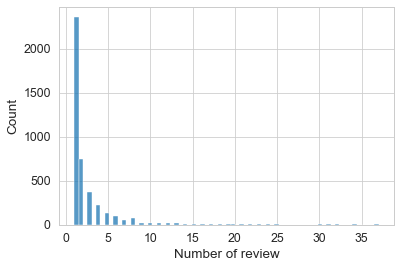

In [13]:
# Histogram of the number of reviews
sns.histplot(data=df, x = 'Number of review', bins=70)

In [14]:
# Mean rating for each business
yelp.groupby('business_id')['stars'].mean()

business_id
-0QBrNvhrPQCaeo7mTo0zQ    4.000000
-0bUDim5OGuv8R0Qqq6J4A    3.000000
-1N0Z3uM8xbxKS8XiAnaog    1.000000
-34jE_5dujSWMIOBudQsiQ    5.000000
-3WVw1TNQbPBzaKCaQQ1AQ    3.333333
                            ...   
zwToyWL4dT1clsFPK9wI2w    3.333333
zxjMiqlfUuIQRltSuj9FpQ    1.000000
zxqvU415r_RtZRKDtdbIKQ    5.000000
zyCrtvCPdSZDhUrH86vbeA    3.000000
zyYRWnimLbQt9aCCI_2MZw    5.000000
Name: stars, Length: 4174, dtype: float64

In [15]:
# Add Mean rating for each business to df
mean_stars = yelp.groupby('business_id')['stars'].mean()
df['Mean Stars'] = df['business_id'].map(mean_stars)

In [16]:
df

,business_id,Number of review,Number of reviewers,Mean Stars
0,9yKzy9PApeiPPOUJEtnvkg,8,8,3.250000
1,ZRJwVLyzEJq1VAihDhYiow,6,6,4.000000
2,6oRAC4uyJCsJl1X0WZpVSA,12,12,4.583333
3,_1QQZuf4zZOyFCvXc0o6Vg,8,8,4.625000
4,6ozycU1RpktNG2-1BroVtw,1,1,5.000000
...,...,...,...,...
4169,62F17L8z4Q4S7U_TayuDBA,1,1,5.000000
4170,4FBHwaMtMQ_x8RQoI2T-jw,1,1,3.000000
4171,qhIlkXgcC4j34lNTIqu9WA,1,1,5.000000
4172,JOZqBKIOB8WEBAWm7v1JFA,1,1,5.000000


In [17]:
df['Number of review'].mean()

2.3957834211787254

In [18]:
# Top ten best business with more than 3 ratings (mean is 2.39)
df[df['Number of review'] > 3].sort_values(by=['Mean Stars'], ascending=False).head(10)

,business_id,Number of review,Number of reviewers,Mean Stars
857,rLAeltELaGdQKh_LYIllEA,5,5,5.000000
1375,yJMLD-6AggZNdC-GonVBsA,4,4,5.000000
238,97Z7j4vH0kfzL10AONi4uA,4,4,5.000000
673,lVkDZZ8sTafPlq7f1i5row,6,6,5.000000
83,O-Xa9GCFWI65YiBD5Jw_hA,7,7,5.000000
1506,fVgrpVyp-nPLTac9YIjTug,4,4,5.000000
2547,U6oNWTxVTnuuCL0BPRZCSg,4,4,5.000000
365,Bm2PBs_AZEtx93zdtwqUJA,4,4,5.000000
1140,pAHUC05ceak48e745i6G4g,4,4,5.000000
1272,KTF-E3NfkJy2wiwcgOPyVQ,6,6,4.833333


In [19]:
# Top ten worst business with more than 3 ratings (mean is 2.39)
df[df['Number of review'] > 3].sort_values(by=['Mean Stars'], ascending=True).head(10)

,business_id,Number of review,Number of reviewers,Mean Stars
3202,5M7YgorCUTEZkKYNbKDHTA,4,4,1.250000
496,nfyqtEoufkhjv97IueK7Ow,6,6,1.333333
1340,WM8sy8FjrU3PpxN_NI02ZA,4,4,1.750000
635,iWlaj4R-2BTsWR7PwL90BQ,4,4,1.750000
475,yRga-WpyfZRz8Es4OpyMhA,4,4,1.750000
443,JJDaF4yFPLgQ3u678qyL2w,4,4,2.000000
1028,fd0iSXEhwz-foQdS8SCKYA,4,4,2.000000
1661,KIgkwPEOxbfdeCk0ltycOQ,4,4,2.000000
1079,QCxXYA13PtkD3wec47_r8Q,5,5,2.000000
980,jEWfxxA_kjeJE_Z_ku3zLA,7,7,2.142857


In [20]:
# Add text length to yelp
yelp['text length'] = yelp['text'].apply(len)

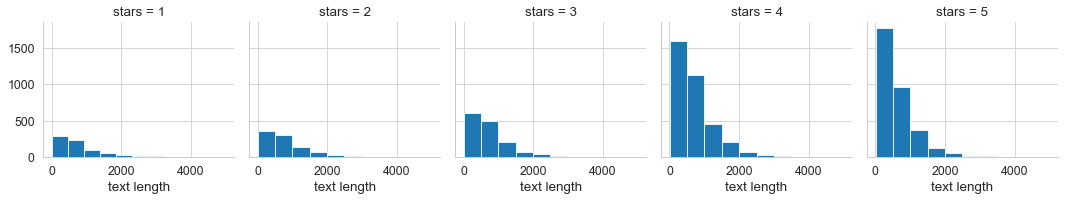

In [21]:
# 5 histograms of text length based off of the star ratings
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length')

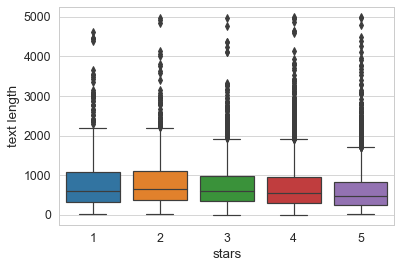

In [22]:
# boxplot of text length for each star category
sns.set_style('whitegrid')
sns.boxplot(x='stars',y='text length',data=yelp)

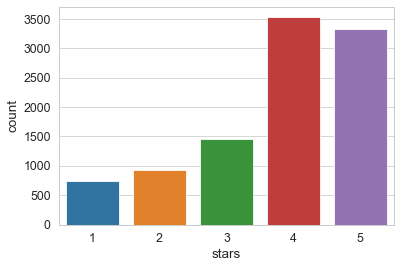

In [23]:
# Countplot of the number of occurrences for each type of star rating
sns.countplot(x='stars',data=yelp)

In [24]:
# Create stars dataframe with mean features: coll, useful, funny, text length
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [25]:
# Correlation
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


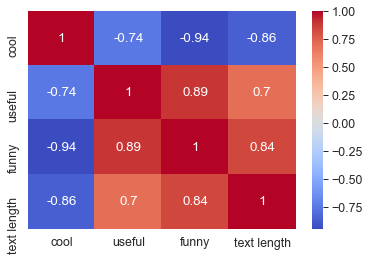

In [26]:
# Correlation using heatmap
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

In [27]:
# Top 10 most active users
yelp.groupby('user_id')['text'].count().sort_values(ascending=False).head(10)

user_id
fczQCSmaWF78toLEmb0Zsw    38
0CMz8YaO3f8xu4KqQgKb9Q    25
90a6z--_CUrl84aCzZyPsg    22
4ozupHULqGyO42s3zNUzOQ    18
0mqHhdKEdak_A1FBhFNXqA    18
wHg1YkCzdZq9WBJOTRgxHQ    17
_PzSNcfrCjeBxSLXRoMmgQ    16
0bNXP9quoJEgyVZu9ipGgQ    16
joIzw_aUiNvBTuGoytrH7g    15
JgDkCER12uiv4lbpmkZ9VA    15
Name: text, dtype: int64

In [28]:
# List of Top 10 most active users

users = ['fczQCSmaWF78toLEmb0Zsw', '0CMz8YaO3f8xu4KqQgKb9Q', '90a6z--_CUrl84aCzZyPsg', 
         '4ozupHULqGyO42s3zNUzOQ', '0mqHhdKEdak_A1FBhFNXqA', 'wHg1YkCzdZq9WBJOTRgxHQ', 
         '_PzSNcfrCjeBxSLXRoMmgQ', '0bNXP9quoJEgyVZu9ipGgQ', 'joIzw_aUiNvBTuGoytrH7g',
        'JgDkCER12uiv4lbpmkZ9VA']

In [29]:
# def text_process(mess):
#     """
#     Takes in a string of text, then performs the following:
#     1. Remove all punctuation
#     2. Remove all stopwords
#     3. Returns a list of the cleaned text
#     """
#     # Check characters to see if they are in punctuation
#     nopunc = [char for char in mess if char not in string.punctuation]

#     # Join the characters again to form the string.
#     nopunc = ''.join(nopunc)
    
#     # Now just remove any stopwords
#     return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [30]:
def clean_text_round1(text):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [31]:
# Create dataframe (dfu) with top 10 most active users
dfu = pd.DataFrame()
for i in users:
    temp = yelp[yelp['user_id'] == i]
    dfu = pd.concat([dfu, temp])

In [32]:
# implement round1 to dfu, and call it dfu_clean
dfu_clean = pd.DataFrame(dfu.text.apply(round1))

In [33]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''
    Get rid of some additional punctuation and non-sensical text 
    that was missed the first time around.
    '''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('user_id', '', text)  # this will help me later
    return text

round2 = lambda x: clean_text_round2(x)

In [34]:
# implement round2 to dfu_clean
dfu_clean = pd.DataFrame(dfu_clean.text.apply(round2))
dfu_clean

,text
567,ive gotta say nordys as my aunt refers to nord...
582,i really dont consider myself a neimans type o...
774,im a sucker for popcorn so when i saw a now op...
817,ice ice babyice ice babyall right stop collabo...
919,out of all of the flos locations this is the o...
...,...
8204,i love fate and have been there dozens of time...
8466,typical chain southwesterntex mex food in a co...
8559,this place is so cool the menus are on the wal...
8786,a new player in the downtown phoenix food scen...


In [35]:
# Change column name
dfu_clean = dfu_clean.rename(columns={'text':'text_clean'})
dfu_clean

,text_clean
567,ive gotta say nordys as my aunt refers to nord...
582,i really dont consider myself a neimans type o...
774,im a sucker for popcorn so when i saw a now op...
817,ice ice babyice ice babyall right stop collabo...
919,out of all of the flos locations this is the o...
...,...
8204,i love fate and have been there dozens of time...
8466,typical chain southwesterntex mex food in a co...
8559,this place is so cool the menus are on the wal...
8786,a new player in the downtown phoenix food scen...


In [36]:
# Concat dfu_clean = cleaned text to dfu
dfu_clean = pd.concat([dfu_clean, dfu], axis = 1, sort = False)
# Drop original text column (replaced by text_clean)
dfu_clean = dfu_clean.drop(columns = 'text')

dfu_clean.head(2)

,text_clean,business_id,date,review_id,stars,type,user_id,cool,useful,funny,text length
567,ive gotta say nordys as my aunt refers to nord...,c7VgGP8xT25OSReok6fwcQ,2009-05-23,LtjtyM0CcVWBNRJ-mfsC_Q,4,review,fczQCSmaWF78toLEmb0Zsw,7,8,4,1078
582,i really dont consider myself a neimans type o...,h8rqIokh6EkM4flR9CjxbA,2009-02-23,5rzUPtAk7rR5EK8x_WszwA,4,review,fczQCSmaWF78toLEmb0Zsw,6,8,2,827


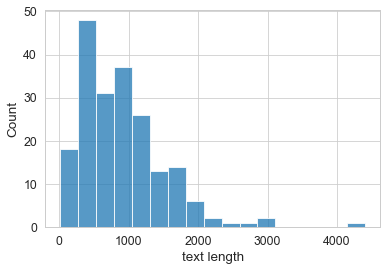

In [37]:
# Text length, after cleaning (top 10 most avtive users)
sns.histplot(data=dfu_clean, x = 'text length')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002CFC934AC8>,
      dtype=object)

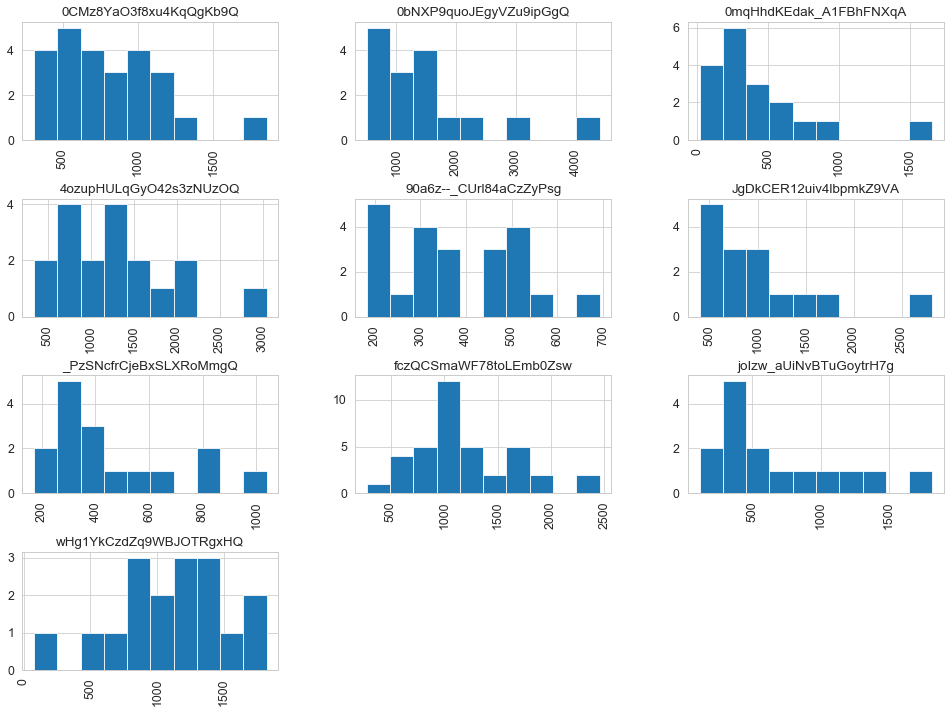

In [38]:
# Text length, after cleaning by top 10 most avtive users
dfu_clean.hist(column='text length', by='user_id',figsize=(16,12))

In [39]:
# Set user_id as index
dfu_clean = dfu_clean.set_index('user_id')

In [40]:
# We are going to create a document-term matrix using CountVectorizer, 
# and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(dfu_clean.text_clean)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = dfu_clean.index
data_dtm = data_dtm.groupby('user_id').sum()
data_dtm = data_dtm.transpose()
data_dtm

user_id,0CMz8YaO3f8xu4KqQgKb9Q,0bNXP9quoJEgyVZu9ipGgQ,0mqHhdKEdak_A1FBhFNXqA,4ozupHULqGyO42s3zNUzOQ,90a6z--_CUrl84aCzZyPsg,JgDkCER12uiv4lbpmkZ9VA,_PzSNcfrCjeBxSLXRoMmgQ,fczQCSmaWF78toLEmb0Zsw,joIzw_aUiNvBTuGoytrH7g,wHg1YkCzdZq9WBJOTRgxHQ
abandoned,0,1,0,0,0,0,0,0,0,0
able,1,2,0,0,0,1,0,1,0,1
aboutand,0,0,0,0,0,0,0,1,0,0
absolutely,0,0,0,1,0,2,0,1,1,0
access,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
zen,0,0,0,0,0,0,0,1,0,0
zero,0,0,1,1,0,0,0,0,0,0
zin,0,2,0,0,0,0,0,0,0,0
zinc,0,0,0,0,0,0,0,0,0,1


In [41]:
# Find the top 30 words said by each reviewer
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'0CMz8YaO3f8xu4KqQgKb9Q': [('good', 28),
  ('little', 19),
  ('place', 19),
  ('really', 18),
  ('pretty', 18),
  ('food', 17),
  ('great', 13),
  ('like', 12),
  ('theyre', 10),
  ('greek', 10),
  ('youll', 9),
  ('right', 9),
  ('lunch', 8),
  ('did', 8),
  ('menu', 8),
  ('think', 8),
  ('nice', 8),
  ('youre', 8),
  ('come', 8),
  ('happy', 7),
  ('just', 7),
  ('cool', 7),
  ('night', 7),
  ('drink', 7),
  ('fun', 7),
  ('bar', 7),
  ('know', 6),
  ('dont', 6),
  ('music', 6),
  ('cute', 6)],
 '0bNXP9quoJEgyVZu9ipGgQ': [('chocolate', 13),
  ('minutes', 13),
  ('cream', 13),
  ('dessert', 12),
  ('server', 12),
  ('thought', 11),
  ('asked', 11),
  ('just', 10),
  ('ice', 10),
  ('like', 10),
  ('time', 10),
  ('try', 10),
  ('dont', 9),
  ('wanted', 9),
  ('came', 9),
  ('didnt', 9),
  ('pancakes', 8),
  ('id', 8),
  ('coffee', 8),
  ('butter', 8),
  ('great', 8),
  ('mousse', 8),
  ('dinner', 8),
  ('long', 7),
  ('dish', 7),
  ('ill', 7),
  ('visit', 7),
  ('good', 7),
  ('sauc

In [42]:
# Print the top 15 words said by each reviewer
for reviewer, top_words in top_dict.items():
    print(reviewer)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

0CMz8YaO3f8xu4KqQgKb9Q
good, little, place, really, pretty, food, great, like, theyre, greek, youll, right, lunch, did
---
0bNXP9quoJEgyVZu9ipGgQ
chocolate, minutes, cream, dessert, server, thought, asked, just, ice, like, time, try, dont, wanted
---
0mqHhdKEdak_A1FBhFNXqA
place, like, bar, just, time, food, service, dont, small, club, good, think, little, great
---
4ozupHULqGyO42s3zNUzOQ
just, like, shop, visit, cake, home, new, breakfast, love, old, area, great, food, fresh
---
90a6z--_CUrl84aCzZyPsg
place, great, good, food, bar, drinks, best, scottsdale, old, just, new, times, friends, quality
---
JgDkCER12uiv4lbpmkZ9VA
place, like, food, just, good, time, way, restaurant, home, ive, im, pork, night, nice
---
_PzSNcfrCjeBxSLXRoMmgQ
good, chicken, food, trail, got, love, great, little, rice, time, crispy, service, quick, checked
---
fczQCSmaWF78toLEmb0Zsw
ive, just, time, im, good, like, ill, night, sure, dont, took, did, salad, say
---
joIzw_aUiNvBTuGoytrH7g
just, like, place, loca

In [43]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each reviewer
words = []
for reviewer in data_dtm.columns:
    top = [word for (word, count) in top_dict[reviewer]]
    for t in top:
        words.append(t)
        
words

['good',
 'little',
 'place',
 'really',
 'pretty',
 'food',
 'great',
 'like',
 'theyre',
 'greek',
 'youll',
 'right',
 'lunch',
 'did',
 'menu',
 'think',
 'nice',
 'youre',
 'come',
 'happy',
 'just',
 'cool',
 'night',
 'drink',
 'fun',
 'bar',
 'know',
 'dont',
 'music',
 'cute',
 'chocolate',
 'minutes',
 'cream',
 'dessert',
 'server',
 'thought',
 'asked',
 'just',
 'ice',
 'like',
 'time',
 'try',
 'dont',
 'wanted',
 'came',
 'didnt',
 'pancakes',
 'id',
 'coffee',
 'butter',
 'great',
 'mousse',
 'dinner',
 'long',
 'dish',
 'ill',
 'visit',
 'good',
 'sauce',
 'love',
 'place',
 'like',
 'bar',
 'just',
 'time',
 'food',
 'service',
 'dont',
 'small',
 'club',
 'good',
 'think',
 'little',
 'great',
 'need',
 'movies',
 'walked',
 'drink',
 'bad',
 'called',
 'pizza',
 'sign',
 'went',
 'pay',
 'bands',
 'pretty',
 'park',
 'way',
 'location',
 'kind',
 'just',
 'like',
 'shop',
 'visit',
 'cake',
 'home',
 'new',
 'breakfast',
 'love',
 'old',
 'area',
 'great',
 'food',


In [44]:
# Let's aggregate this list and identify the most common words along 
# with how many routines they occur in
Counter(words).most_common()

[('good', 10),
 ('like', 10),
 ('great', 9),
 ('just', 9),
 ('place', 7),
 ('food', 7),
 ('dont', 7),
 ('service', 7),
 ('time', 6),
 ('little', 5),
 ('really', 5),
 ('pretty', 5),
 ('bar', 5),
 ('menu', 4),
 ('nice', 4),
 ('night', 4),
 ('visit', 4),
 ('location', 4),
 ('ive', 4),
 ('right', 3),
 ('did', 3),
 ('drink', 3),
 ('know', 3),
 ('didnt', 3),
 ('sauce', 3),
 ('love', 3),
 ('walked', 3),
 ('went', 3),
 ('breakfast', 3),
 ('chicken', 3),
 ('im', 3),
 ('order', 3),
 ('think', 2),
 ('cool', 2),
 ('chocolate', 2),
 ('try', 2),
 ('came', 2),
 ('pancakes', 2),
 ('ill', 2),
 ('small', 2),
 ('pizza', 2),
 ('way', 2),
 ('home', 2),
 ('new', 2),
 ('old', 2),
 ('drinks', 2),
 ('times', 2),
 ('friends', 2),
 ('people', 2),
 ('prices', 2),
 ('took', 2),
 ('served', 2),
 ('theyre', 1),
 ('greek', 1),
 ('youll', 1),
 ('lunch', 1),
 ('youre', 1),
 ('come', 1),
 ('happy', 1),
 ('fun', 1),
 ('music', 1),
 ('cute', 1),
 ('minutes', 1),
 ('cream', 1),
 ('dessert', 1),
 ('server', 1),
 ('thought',

In [45]:
add_stop_words = ['dont', 'ive', 'did', 'didnt', 'im', 'id', 'ago', 'b', 't', 'went', 'o', 's', 'se']
add_stop_words

['dont',
 'ive',
 'did',
 'didnt',
 'im',
 'id',
 'ago',
 'b',
 't',
 'went',
 'o',
 's',
 'se']

In [46]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(dfu_clean.text_clean)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = dfu_clean.index

In [47]:
# Let's make some word clouds!
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [48]:
# create empty dictionary
text_all = {}

# input all reviews (in one cell) of each reviewer into the dictionary
for i in users:
    text_all[i] = dfu_clean[dfu_clean.index == i].iloc[:]['text_clean'].to_string(index=False)
    
# Create dataframe with our dictionary 
dfu_text_all = pd.DataFrame(data=text_all, index = ['text_all'])

In [49]:
# Transpose dataframe. So now we have user_id as index, and column text_all which include all reviews
dfu_text_all = dfu_text_all.transpose()
dfu_text_all

,text_all
fczQCSmaWF78toLEmb0Zsw,user_id\n ive gotta say nordys as my aunt refe...
0CMz8YaO3f8xu4KqQgKb9Q,user_id\n screw disneyland sephora is the happ...
90a6z--_CUrl84aCzZyPsg,user_id\n i have been coming to this bar for o...
4ozupHULqGyO42s3zNUzOQ,user_id\n ritas kitchen is a hidden gem locate...
0mqHhdKEdak_A1FBhFNXqA,user_id\n jersey mikes is okay its a chain pla...
wHg1YkCzdZq9WBJOTRgxHQ,user_id\n somehow while attempting to write an...
_PzSNcfrCjeBxSLXRoMmgQ,user_id\n this is my time to this amc i like...
0bNXP9quoJEgyVZu9ipGgQ,user_id\n ate here months ago was excited to ...
joIzw_aUiNvBTuGoytrH7g,user_id\n after repeat visits it just gets wor...
JgDkCER12uiv4lbpmkZ9VA,user_id\n i used to frequent the lost leaf alm...


In [50]:
# Implement to dfu_text_all round2 function to get rid of 'user_id\n'
dfu_text_all = pd.DataFrame(dfu_text_all.text_all.apply(round2))
dfu_text_all

,text_all
fczQCSmaWF78toLEmb0Zsw,ive gotta say nordys as my aunt refers to nor...
0CMz8YaO3f8xu4KqQgKb9Q,screw disneyland sephora is the happiest plac...
90a6z--_CUrl84aCzZyPsg,i have been coming to this bar for over now ...
4ozupHULqGyO42s3zNUzOQ,ritas kitchen is a hidden gem located right s...
0mqHhdKEdak_A1FBhFNXqA,jersey mikes is okay its a chain place and a ...
wHg1YkCzdZq9WBJOTRgxHQ,somehow while attempting to write an update t...
_PzSNcfrCjeBxSLXRoMmgQ,this is my time to this amc i like it it i...
0bNXP9quoJEgyVZu9ipGgQ,ate here months ago was excited to finally f...
joIzw_aUiNvBTuGoytrH7g,after repeat visits it just gets worse the s...
JgDkCER12uiv4lbpmkZ9VA,i used to frequent the lost leaf almost daily...


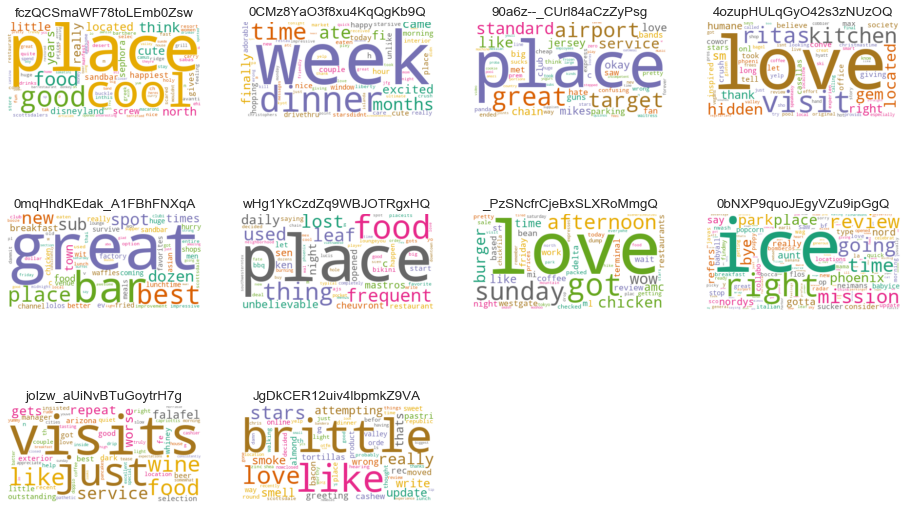

In [51]:
# Reset the output dimensions

plt.rcParams['figure.figsize'] = [16, 10]

# users_id - reviewers
full_names = ['fczQCSmaWF78toLEmb0Zsw', '0CMz8YaO3f8xu4KqQgKb9Q', '90a6z--_CUrl84aCzZyPsg', 
         '4ozupHULqGyO42s3zNUzOQ', '0mqHhdKEdak_A1FBhFNXqA', 'wHg1YkCzdZq9WBJOTRgxHQ', 
         '_PzSNcfrCjeBxSLXRoMmgQ', '0bNXP9quoJEgyVZu9ipGgQ', 'joIzw_aUiNvBTuGoytrH7g',
        'JgDkCER12uiv4lbpmkZ9VA']

# Create subplots for each reviewer
for index, reviewer in enumerate(data_dtm.columns):
    wc.generate(dfu_text_all.text_all[reviewer])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

In [52]:
# Create quick lambda functions to find the polarity and subjectivity of each routine

from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

dfu_text_all['polarity'] = dfu_text_all['text_all'].apply(pol)
dfu_text_all['subjectivity'] = dfu_text_all['text_all'].apply(sub)
dfu_text_all

,text_all,polarity,subjectivity
fczQCSmaWF78toLEmb0Zsw,ive gotta say nordys as my aunt refers to nor...,0.135100,0.522654
0CMz8YaO3f8xu4KqQgKb9Q,screw disneyland sephora is the happiest plac...,0.352885,0.630769
90a6z--_CUrl84aCzZyPsg,i have been coming to this bar for over now ...,0.396283,0.504711
4ozupHULqGyO42s3zNUzOQ,ritas kitchen is a hidden gem located right s...,0.228835,0.575744
0mqHhdKEdak_A1FBhFNXqA,jersey mikes is okay its a chain place and a ...,0.162585,0.492630
wHg1YkCzdZq9WBJOTRgxHQ,somehow while attempting to write an update t...,0.221296,0.481481
_PzSNcfrCjeBxSLXRoMmgQ,this is my time to this amc i like it it i...,0.116296,0.654815
0bNXP9quoJEgyVZu9ipGgQ,ate here months ago was excited to finally f...,0.328872,0.684512
joIzw_aUiNvBTuGoytrH7g,after repeat visits it just gets worse the s...,0.072198,0.579203
JgDkCER12uiv4lbpmkZ9VA,i used to frequent the lost leaf almost daily...,0.164141,0.477462


In [53]:
# Top 10 most cool reviewers
yelp.groupby('user_id')['cool'].agg('mean').sort_values(ascending=False).head(10)

user_id
73eZuIuXVD5sif7GrIMfuQ    77.000000
u5bvcT_3Go0O3Xk4Am8CWQ    16.000000
J3rNWRLRuZJ_0xsJalIhlA    16.000000
w6Vv-kldGpmvSGqXvTbAdQ    16.000000
C8ZTiwa7qWoPSMIivTeSfw    15.222222
emNXAAschSlcvqmDZFj5TA    15.000000
GLMX8Is_Ur6aIVV86Ok0Lw    15.000000
saiZmxzBIowJbMgPBW1Now    14.000000
mOirLg2h76o-dPn97XxzoA    13.000000
7T2ul_LOzArDKjfVRDt-JA    13.000000
Name: cool, dtype: float64

In [54]:
# Top 10 most useful reviewers
yelp.groupby('user_id')['useful'].agg('mean').sort_values(ascending=False).head(10)

user_id
73eZuIuXVD5sif7GrIMfuQ    76.000000
J3rNWRLRuZJ_0xsJalIhlA    19.000000
saiZmxzBIowJbMgPBW1Now    18.000000
w6Vv-kldGpmvSGqXvTbAdQ    17.000000
C8ZTiwa7qWoPSMIivTeSfw    15.888889
GLMX8Is_Ur6aIVV86Ok0Lw    15.000000
emNXAAschSlcvqmDZFj5TA    15.000000
u5bvcT_3Go0O3Xk4Am8CWQ    15.000000
DPsmPEPp-TfNDaHiz7czSQ    15.000000
7T2ul_LOzArDKjfVRDt-JA    14.000000
Name: useful, dtype: float64

In [55]:
# Top 10 most funny reviewers
yelp.groupby('user_id')['funny'].agg('mean').sort_values(ascending=False).head(10)

user_id
J3rNWRLRuZJ_0xsJalIhlA    24.000000
C8ZTiwa7qWoPSMIivTeSfw    20.444444
emNXAAschSlcvqmDZFj5TA    20.000000
lhf22sqBafQv6CXu2fCmvg    20.000000
w6Vv-kldGpmvSGqXvTbAdQ    17.000000
GLMX8Is_Ur6aIVV86Ok0Lw    17.000000
2UPPp-p0Yk7l56o75ZCIBg    17.000000
7T2ul_LOzArDKjfVRDt-JA    15.000000
u5bvcT_3Go0O3Xk4Am8CWQ    14.000000
SbzANP6hRVwDU5pbtz5ANw    14.000000
Name: funny, dtype: float64

In [56]:
# Top 10 most useful reviews
yelp.sort_values(by = 'useful', ascending=False).head(10)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
4957,gqLWBFxOKag8dXwVxEvTrg,2011-10-03,1kc50TqtMsIHDGR8yQgF8g,5,Love this place! Amazing Happy Hour Specials!!,review,73eZuIuXVD5sif7GrIMfuQ,77,76,0,46
9634,1NZLxU5WvB5roPFzneAlLw,2008-09-19,nQHI2kQElYrMWrPBqdwE4w,4,Scary things to me:\nParis Hilton has a career...,review,C8ZTiwa7qWoPSMIivTeSfw,38,38,57,1738
6495,l0S5b8YYyDbjttTWtKc-gg,2012-06-20,ZpkGGIcD1zX5Pc4p4c93fA,5,Why'd the chicken cross the road?\nTo get to F...,review,cRyNICH0mhjxagvSyVr60Q,27,31,24,1664
9843,WS1z1OAR0tRl4FsjdTGUFQ,2010-07-12,fD2_M3N0Ojx7d1LZ4lNSMA,5,"As far as I know, I'm the only person in this ...",review,MWt24-6bfv_OHLKhwMQ0Tw,32,30,20,1412
180,pfTwzep_4hRTX_jXoi38cw,2008-05-27,RqwFPp_qPu-1h87pGBAM8w,5,Hippies scare me. So in my preparation to ...,review,sEWeeq41k4ohBz4jS_iGRw,28,28,39,1039
4637,rQ4z0EStSZE4acgkne6Hmg,2009-01-28,PWvLDC7tQWRoajYKcAqrxQ,5,I really enjoy this place. It's beautifully de...,review,sEWeeq41k4ohBz4jS_iGRw,23,24,11,612
556,V9i9LnTg9H2XvzqCVBSOXg,2009-05-09,YAXPKM-Hck6-mjF74Zy9tA,4,"Tandoori Times\n\nVolume 1, Issue 1, Number 1....",review,P2kVk4cIWyK4e4h14RhK-Q,22,23,27,2185
778,AqbgC7Gul5Es1rRzGNLDFA,2008-06-10,WRBYytJAaJI1BTQG5VI8oQ,1,Yeah...notsomuch.\n\nSprinkles is sooooooooo n...,review,g84VjttN28PWiv_WtdhnSQ,17,20,30,2162
741,IuAPYzf3NSyfyXYgT46YVA,2010-09-26,sA_wkvAZpt4Hm6AXGecKNA,5,FnB is how every restaurant should be. Unfortu...,review,AdEy5KAIlMAy8xHyuMQCFg,17,20,10,950
174,NBwPgX7L2D-EZedgo3A-pw,2009-08-18,roMeHsyf55-_O7rpudBbZA,4,Gils.. A relatively new business to the comple...,review,C6IOtaaYdLIT5fWd7ZYIuA,16,19,5,1149


In [57]:
# The most useful and cool review
yelp[yelp['review_id'] == '1kc50TqtMsIHDGR8yQgF8g']['text']

4957    Love this place! Amazing Happy Hour Specials!!
Name: text, dtype: object

## PREDICTIONS

To make things a little easier, I grabbed reviews that were either 1 star or 5 stars.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report

### On original data

In [59]:
# Create a dataframe called yelp_class that contains the columns of yelp dataframe 
# but for only the 1 or 5 star reviews

In [60]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]

In [61]:
X = yelp_class['text']
y = yelp_class['stars']

In [62]:
cv = CountVectorizer()

In [63]:
# Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). 
# Save this result by overwriting X
X = cv.fit_transform(X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [65]:
# MultinomialNB and create an instance of the estimator and call is nb
nb = MultinomialNB()

In [66]:
# Now fit nb using the training data.
nb.fit(X_train,y_train)

MultinomialNB()

In [67]:
# Use the predict method off of nb to predict labels from X_test
predictions = nb.predict(X_test)

In [68]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[137  81]
 [ 37 971]]


              precision    recall  f1-score   support

           1       0.79      0.63      0.70       218
           5       0.92      0.96      0.94      1008

    accuracy                           0.90      1226
   macro avg       0.86      0.80      0.82      1226
weighted avg       0.90      0.90      0.90      1226



### On cleaned data

In [69]:
dfu_clean = dfu_clean[(dfu_clean.stars==1) | (dfu_clean.stars==5)]

In [70]:
X = dfu_clean['text_clean']
y = dfu_clean['stars']

In [71]:
cv = CountVectorizer()

In [72]:
# Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). 
# Save this result by overwriting X
X = cv.fit_transform(X)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [74]:
# MultinomialNB and create an instance of the estimator and call is nb
nb = MultinomialNB()

In [75]:
# Now fit nb using the training data.
nb.fit(X_train,y_train)

MultinomialNB()

In [76]:
# Use the predict method off of nb to predict labels from X_test
predictions = nb.predict(X_test)

In [77]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[18]]


              precision    recall  f1-score   support

           5       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

